In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-03 13:43:10.290553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=3)

In [3]:
def real():
    qml.Rot( 0.0,np.pi/2, np.pi/6,wires=0)

In [24]:
print(qml.draw(real)())

0: ──Rot(0.00,1.57,0.52)─┤  


In [4]:
def generator(w,**kwargs):
    qml.RX(w[0], wires=1)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=1)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=1)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[1,2])
    qml.RX(w[6], wires=1)
    qml.RY(w[7], wires=1)
    qml.RZ(w[8], wires=1)
    qml.Rot(0.0, np.pi/2, -np.pi/6,wires=1)

In [25]:
print(qml.draw(generator)([ 0,0,0,0,0,0,0,0,0]))

1: ──RX(0.00)──RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)─┤  
2: ──RX(0.00)──RY(0.00)──RZ(0.00)─╰X─────────────────────────────────────────────────────┤  


In [26]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    #qml.Identity(w[0], wires=0)
    #qml.Identity(w[1], wires=1)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

In [27]:
print(qml.draw(discriminator)([]))

0: ──H─╭Z──H─┤  
1: ────╰●──H─┤  


In [28]:
@qml.qnode(dev, interface='tf')
def real_gen_disc_circuit(gen_weights,disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))
#qml.expval(qml.PauliZ(0) @ qml.PauliX(2))

In [29]:
print(qml.draw(real_gen_disc_circuit)([ 0,0,0,0,0,0,0,0,0],[]))

0: ──Rot(0.00,1.57,0.52)──H────────────────────────────────────────────────────────────────────────
1: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╭●──RX(0.00)──RY(0.00)──RZ(0.00)──Rot(0.00,1.57,-0.52)
2: ──RX(0.00)─────────────RY(0.00)──RZ(0.00)─╰X────────────────────────────────────────────────────

──╭Z──H─┤ ╭<𝓗>
──╰●──H─┤ ╰<𝓗>
────────┤     


In [14]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [30]:
def disc_cost(disc_weights):
    cost = -prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [31]:
np.random.seed(0)
eps = 1e-2
#init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   #np.random.normal(scale=eps, size=(9,))
    
init_gen_weights = np.array([0]*9)
init_disc_weights = np.random.normal(size=(2,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

In [17]:
real_gen_disc_circuit(gen_weights, disc_weights)
prob_discriminated(gen_weights,disc_weights)

<tf.Tensor: shape=(), dtype=float64, numpy=0.12499999999999989>

In [32]:
loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
p = 0.1
epochs = 3
for i in range(epochs):
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step_g.append(step)
            print("Step {}: cost = {}".format(step, loss_val))

Step 0: cost = 0.10674188555259179
Step 5: cost = 0.04388833928409608
Step 10: cost = 0.016334822500269935
Step 15: cost = 0.005833389123391153
Step 20: cost = 0.002051310316400712
Step 25: cost = 0.0007173806144641082
Step 30: cost = 0.0002503955666288693
Step 35: cost = 8.73392416708696e-05
Step 40: cost = 3.0457166928204993e-05
Step 45: cost = 1.062022627040804e-05
Step 0: cost = 3.703100890234401e-06
Step 5: cost = 1.2911983532648552e-06
Step 10: cost = 4.502138631901076e-07
Step 15: cost = 1.5697996733066155e-07
Step 20: cost = 5.4735541682449096e-08
Step 25: cost = 1.9085104496774363e-08
Step 30: cost = 6.654564455033096e-09
Step 35: cost = 2.3203032550878078e-09
Step 40: cost = 8.090397241033997e-10
Step 45: cost = 2.8209468094786416e-10
Step 0: cost = 9.836034764454382e-11
Step 5: cost = 3.4296065987149404e-11
Step 10: cost = 1.1958323220540024e-11
Step 15: cost = 4.169609102433469e-12
Step 20: cost = 1.4538370507466425e-12
Step 25: cost = 5.069000774682308e-13
Step 30: cost = 

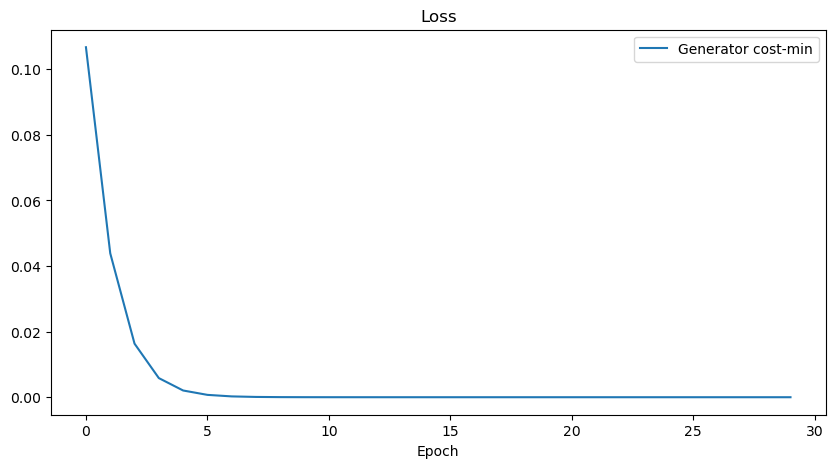

In [33]:
#loss_d = [ 1-x for x in loss_val_d]
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator cost-min")
#plt.plot(range(len(step_d)), loss_d, label="Discriminator cost-max")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [34]:
obs0 = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]
obs1 = [qml.PauliX(1), qml.PauliY(1), qml.PauliZ(1)]

@qml.qnode(dev, interface="tf")
def bloch_vector_real():
    real()
    return [qml.expval(o) for o in obs0]

@qml.qnode(dev, interface="tf")
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs1]

print(f"Real Bloch vector: {bloch_vector_real()}")
print()
print(f"Generator Bloch vector: {bloch_vector_generator(var_g)}")

Real Bloch vector: [tensor(0.8660254, requires_grad=True), tensor(0.5, requires_grad=True), tensor(1.11022302e-16, requires_grad=True)]

Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=0.8660254841015099>, <tf.Tensor: shape=(), dtype=float64, numpy=0.4999998608867261>, <tf.Tensor: shape=(), dtype=float64, numpy=2.220446049250313e-16>]
